# Import and Crop Planet Imagery to study area


In [30]:
import os
import rasterio
from rasterio.windows import from_bounds
from pyproj import Transformer
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

#To run the analysis, simply delete the three quatation marks wherever they appear
"""
# Root directory containing PSScene folders
psscene_root = "files/PSScene"
output_folder = "cropped_outputs"
os.makedirs(output_folder, exist_ok=True)

# Lat/lon bounding box
lat_min, lat_max = 47.0520, 47.0704
lon_min, lon_max = -109.969, -109.946

# Reproject bounding box to UTM (EPSG:32612)
transformer = Transformer.from_crs("EPSG:4326", "EPSG:32612", always_xy=True)
x_min, y_min = transformer.transform(lon_min, lat_min)
x_max, y_max = transformer.transform(lon_max, lat_max)

# Traverse all subdirectories of PSScene
for root, dirs, files in os.walk(psscene_root):
    for filename in files:
        if filename.lower().endswith(".tif") and "analytic" in filename.lower():
            input_path = os.path.join(root, filename)
            output_path = os.path.join(output_folder, f"cropped_{filename}")

            try:
                with rasterio.open(input_path) as src:
                    window = from_bounds(x_min, y_min, x_max, y_max, transform=src.transform)
                    window = window.round_offsets().round_lengths()
                    cropped_data = src.read(window=window)
                    cropped_transform = src.window_transform(window)

                    profile = src.profile.copy()
                    profile.update({
                        "height": window.height,
                        "width": window.width,
                        "transform": cropped_transform
                    })

                    with rasterio.open(output_path, 'w', **profile) as dst:
                        dst.write(cropped_data)

                    print(f"Cropped and saved: {output_path}")

                    # Plot first band
                    plt.figure(figsize=(10, 6))
                    plt.imshow(cropped_data[0], cmap='viridis')
                    plt.colorbar(label='Pixel Value')
                    plt.title(f"Cropped: {filename}")
                    plt.xlabel("Column")
                    plt.ylabel("Row")
                    plt.tight_layout()
                    plt.show()

            except Exception as e:
                print(f"Error processing {input_path}: {e}")

"""


'\n# Root directory containing PSScene folders\npsscene_root = "files/PSScene"\noutput_folder = "cropped_outputs"\nos.makedirs(output_folder, exist_ok=True)\n\n# Lat/lon bounding box\nlat_min, lat_max = 47.0520, 47.0704\nlon_min, lon_max = -109.969, -109.946\n\n# Reproject bounding box to UTM (EPSG:32612)\ntransformer = Transformer.from_crs("EPSG:4326", "EPSG:32612", always_xy=True)\nx_min, y_min = transformer.transform(lon_min, lat_min)\nx_max, y_max = transformer.transform(lon_max, lat_max)\n\n# Traverse all subdirectories of PSScene\nfor root, dirs, files in os.walk(psscene_root):\n    for filename in files:\n        if filename.lower().endswith(".tif") and "analytic" in filename.lower():\n            input_path = os.path.join(root, filename)\n            output_path = os.path.join(output_folder, f"cropped_{filename}")\n\n            try:\n                with rasterio.open(input_path) as src:\n                    window = from_bounds(x_min, y_min, x_max, y_max, transform=src.transf

## NDVI Calculation

In [31]:
import os
import rasterio
import numpy as np

input_folder = "cropped_outputs"
output_folder = "ndvi_calculated"
os.makedirs(output_folder, exist_ok=True)

for file in os.listdir(input_folder):
    if file.endswith(".tif"):
        input_path = os.path.join(input_folder, file)

        with rasterio.open(input_path) as src:
            if src.count < 4:
                print(f"Skipping {file}: not enough bands")
                continue

            # PlanetScope AnalyticMS: Band 3 = Red, Band 4 = NIR
            red = src.read(3).astype('float32')
            nir = src.read(4).astype('float32')

            # NDVI Calculation
            ndvi = np.where(
                (nir + red) == 0,
                0,
                (nir - red) / (nir + red)
            )

            profile = src.profile
            profile.update(dtype='float32', count=1)

            output_filename = os.path.splitext(file)[0] + "_NDVI.tif"
            output_path = os.path.join(output_folder, output_filename)

            with rasterio.open(output_path, 'w', **profile) as dst:
                dst.write(ndvi, 1)




## Plot NDVI Tiffs

In [ ]:
import os
import rasterio
import matplotlib.pyplot as plt
"""
ndvi_folder = "ndvi_calculated"

for file in os.listdir(ndvi_folder):
    if file.endswith(".tif"):
        ndvi_path = os.path.join(ndvi_folder, file)
        with rasterio.open(ndvi_path) as src:
            ndvi = src.read(1)
            
            plt.figure(figsize=(8, 6))
            plt.imshow(ndvi, cmap='RdYlGn', vmin=-1, vmax=1)
            plt.colorbar(label='NDVI')
            plt.title(f"NDVI: {file}")
            plt.axis('off')
            plt.tight_layout()
            plt.show()


## Plot one NDVI with Farm Plot shapefile

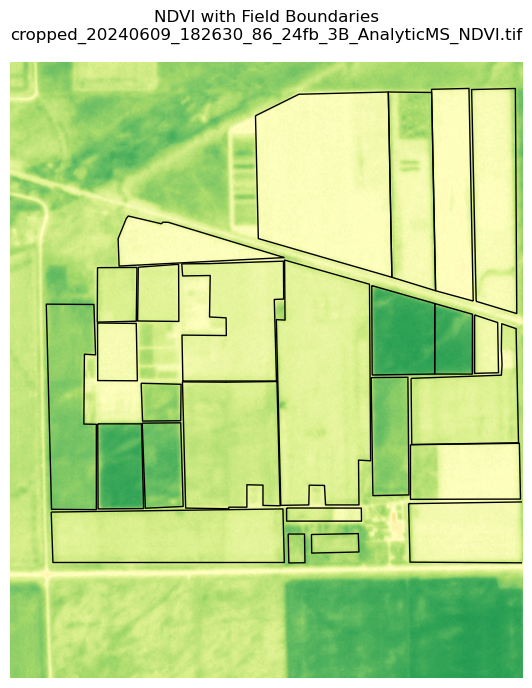

In [3]:
import geopandas as gpd
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
import os

# Paths
shapefile_path = "fields_merge.geojson"  # your crop boundaries
ndvi_folder = "ndvi_calculated"
target_ndvi_file = "cropped_20240609_182630_86_24fb_3B_AnalyticMS_NDVI.tif" # Input one NDVI file here
ndvi_path = os.path.join(ndvi_folder, target_ndvi_file)

# Read shapefile
fields = gpd.read_file(shapefile_path)

# Open NDVI raster
with rasterio.open(ndvi_path) as src:
    ndvi = src.read(1)
    ndvi_bounds = src.bounds
    ndvi_crs = src.crs

    # Reproject fields to NDVI CRS if needed
    if fields.crs != ndvi_crs:
        fields = fields.to_crs(ndvi_crs)

    # Plot
    fig, ax = plt.subplots(figsize=(10, 8))
    show(ndvi, transform=src.transform, cmap='RdYlGn', ax=ax, vmin=-1, vmax=1)
    fields.boundary.plot(ax=ax, edgecolor='black', linewidth=1)
    plt.title(f"NDVI with Field Boundaries\n{target_ndvi_file}")
    plt.axis('off')
    plt.show()





## Clip All NDVI Files to the Shapefile

In [4]:
import os
import rasterio
from rasterio.mask import mask
import geopandas as gpd

# Paths
ndvi_input_folder = "ndvi_calculated"
ndvi_output_folder = "ndvi_clipped_to_fields"
shapefile_path = "fields_merge.geojson"

# Create output folder if it doesn't exist
os.makedirs(ndvi_output_folder, exist_ok=True)

# Load field polygons
fields = gpd.read_file(shapefile_path)
fields = fields.to_crs("EPSG:32612")  # Adjust to your NDVI CRS if needed
geometry = fields.geometry.values

# Loop over NDVI files
for file in os.listdir(ndvi_input_folder):
    if file.endswith(".tif"):
        input_path = os.path.join(ndvi_input_folder, file)
        output_path = os.path.join(ndvi_output_folder, file)

        with rasterio.open(input_path) as src:
            # Reproject shapes to raster CRS
            if fields.crs != src.crs:
                shapes = fields.to_crs(src.crs).geometry
            else:
                shapes = geometry

            # Clip
            out_image, out_transform = mask(src, shapes, crop=True)
            out_meta = src.meta.copy()

            # Update metadata
            out_meta.update({
                "height": out_image.shape[1],
                "width": out_image.shape[2],
                "transform": out_transform
            })

            with rasterio.open(output_path, "w", **out_meta) as dest:
                dest.write(out_image)

print(f"All NDVI rasters clipped and saved to: {ndvi_output_folder}")


All NDVI rasters clipped and saved to: ndvi_clipped_to_fields


## Plot Cropped (to shapefile) NDVI Files 

In [ ]:
import os
import rasterio
import matplotlib.pyplot as plt
"""
# Path to the folder containing clipped NDVI rasters
ndvi_clipped_folder = "ndvi_clipped_to_fields"

# Loop through each clipped NDVI file
for file in os.listdir(ndvi_clipped_folder):
    if file.endswith(".tif"):
        ndvi_path = os.path.join(ndvi_clipped_folder, file)

        # Open the NDVI raster
        with rasterio.open(ndvi_path) as src:
            ndvi = src.read(1)

            # Plot each NDVI raster
            plt.figure(figsize=(8, 6))
            plt.imshow(ndvi, cmap='RdYlGn', vmin=-1, vmax=1)
            plt.colorbar(label='NDVI')
            plt.title(f"Clipped NDVI: {file}")
            plt.axis('off')
            plt.tight_layout()
            plt.show()


## Create Time Series of each Farm Plot and Display

In [25]:
import os
import geopandas as gpd
import rasterstats
import matplotlib.pyplot as plt
import pandas as pd

# Paths
ndvi_clipped_folder = "ndvi_clipped_to_fields"
shapefile_path = "fields_merge.geojson"

# Load the shapefile (fields)
fields = gpd.read_file(shapefile_path)
fields = fields.to_crs("EPSG:32612")  # Match CRS with rasters

# Get list of NDVI raster files, sorted by date
ndvi_files = sorted([f for f in os.listdir(ndvi_clipped_folder) if f.endswith("_NDVI.tif")])

# Use FieldNum as plot names
plot_names = fields["FieldNum"].astype(str).tolist()

# Initialize the time series DataFrame
time_series = pd.DataFrame(columns=["Date"] + plot_names)

# Loop through raster files and extract mean NDVI per plot
for ndvi_file in ndvi_files:
    date_str = ndvi_file.split('_')[1]  # e.g., '20230705'
    date = pd.to_datetime(date_str, format='%Y%m%d')
    ndvi_path = os.path.join(ndvi_clipped_folder, ndvi_file)

    stats = rasterstats.zonal_stats(fields, ndvi_path, stats="mean")
    mean_values = [stat['mean'] for stat in stats]

    new_row = pd.DataFrame([[date] + mean_values], columns=time_series.columns)
    time_series = pd.concat([time_series, new_row], ignore_index=True)




/tmp/ipykernel_2123565/39177545.py:34: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  time_series = pd.concat([time_series, new_row], ignore_index=True)
/tmp/ipykernel_2123565/39177545.py:34: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  time_series = pd.concat([time_series, new_row], ignore_index=True)
/tmp/ipykernel_2123565/39177545.py:34: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or 

## Save Time Series Graphs to Folder

In [26]:
# Create a new folder for saving the graphs
output_folder = "NDVI_TS_Graphs"
os.makedirs(output_folder, exist_ok=True)

# Loop over each actual FieldNum
for plot_name in plot_names:
    plt.figure(figsize=(12, 8))
    plt.plot(time_series['Date'], time_series[plot_name], label=f"Plot {plot_name}")
    plt.xlabel("Date")
    plt.ylabel("Mean NDVI")
    plt.title(f"NDVI Time Series for Plot {plot_name}")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.legend()

    # Save the figure to the new folder
    output_path = os.path.join(output_folder, f"ndvi_plot_{plot_name}.png")
    plt.savefig(output_path, dpi=300)
    plt.close()


## Map of Farm plots

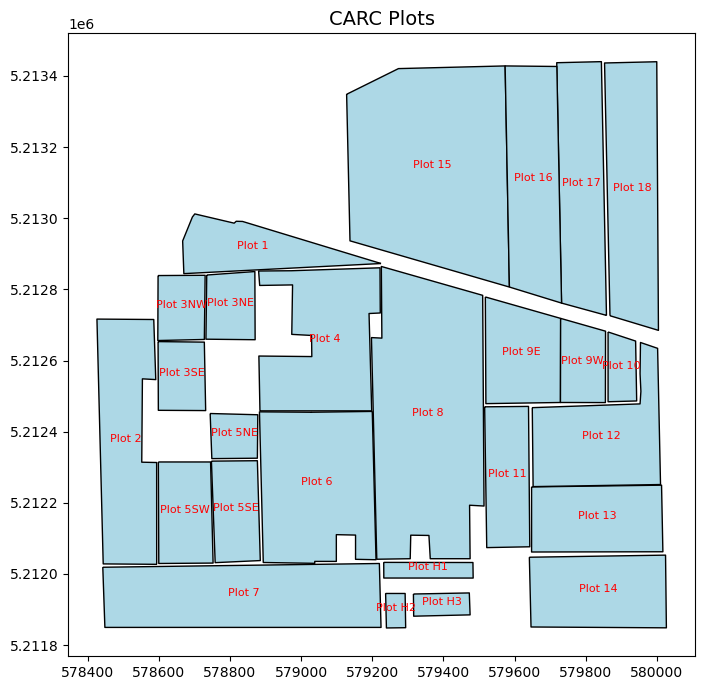

In [10]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Load the shapefile
fields = gpd.read_file("fields_merge.geojson")

# Ensure the shapefile is in the same CRS as your raster data (optional)
fields = fields.to_crs("EPSG:32612")  # Example CRS, adjust as needed

# Plot the shapefile
fig, ax = plt.subplots(figsize=(10, 7))
fields.plot(ax=ax, color='lightblue', edgecolor='black')

# Add labels (e.g., Plot Numbers or Field Names) at the centroid of each plot
for idx, row in fields.iterrows():
    # Get the centroid of the polygon (coordinates for text positioning)
    centroid = row['geometry'].centroid
    # Use the field name or number for labeling
    ax.text(centroid.x, centroid.y, f"Plot {row['FieldNum']}", fontsize=8, ha='center', color='red')

# Set title and labels
ax.set_title("CARC Plots", fontsize=14)
plt.tight_layout()

# Show the plot
plt.show()


## Create Summary Graphs

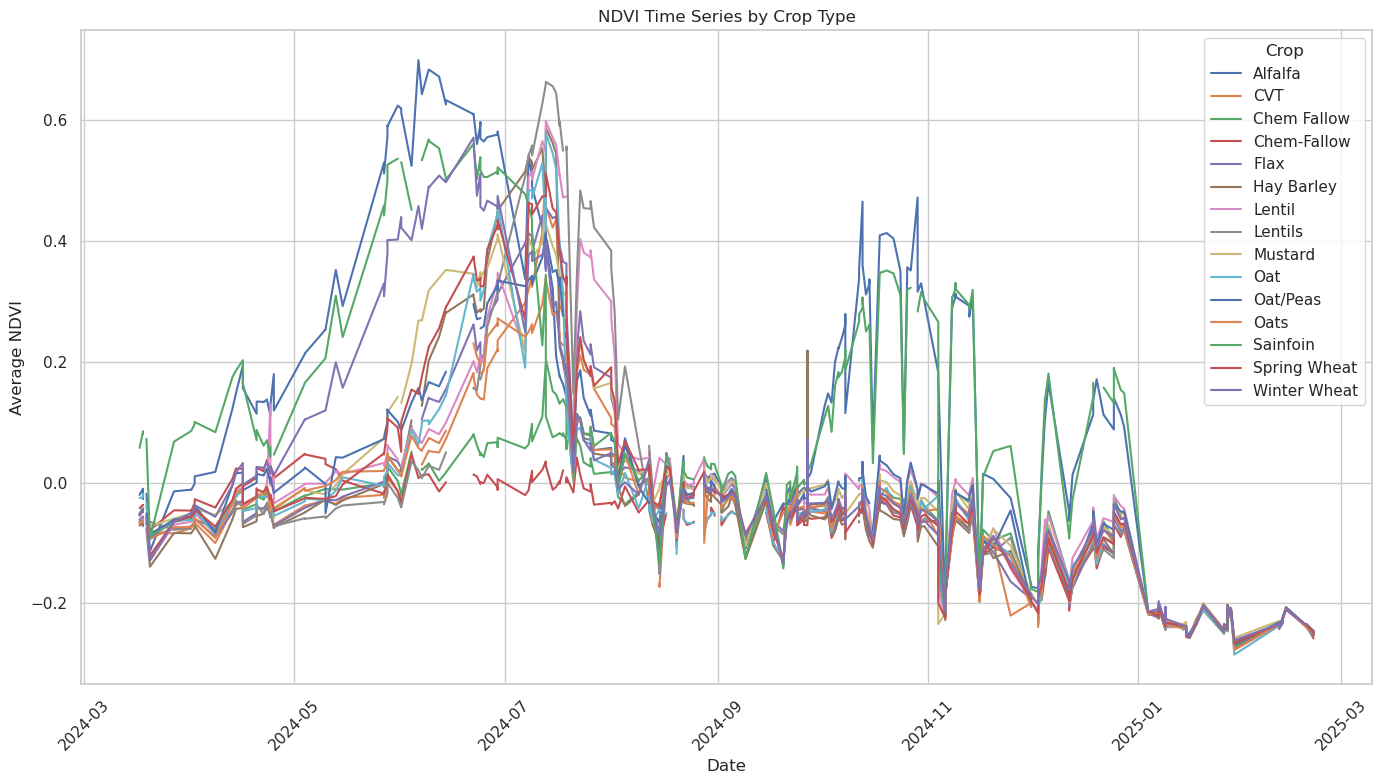

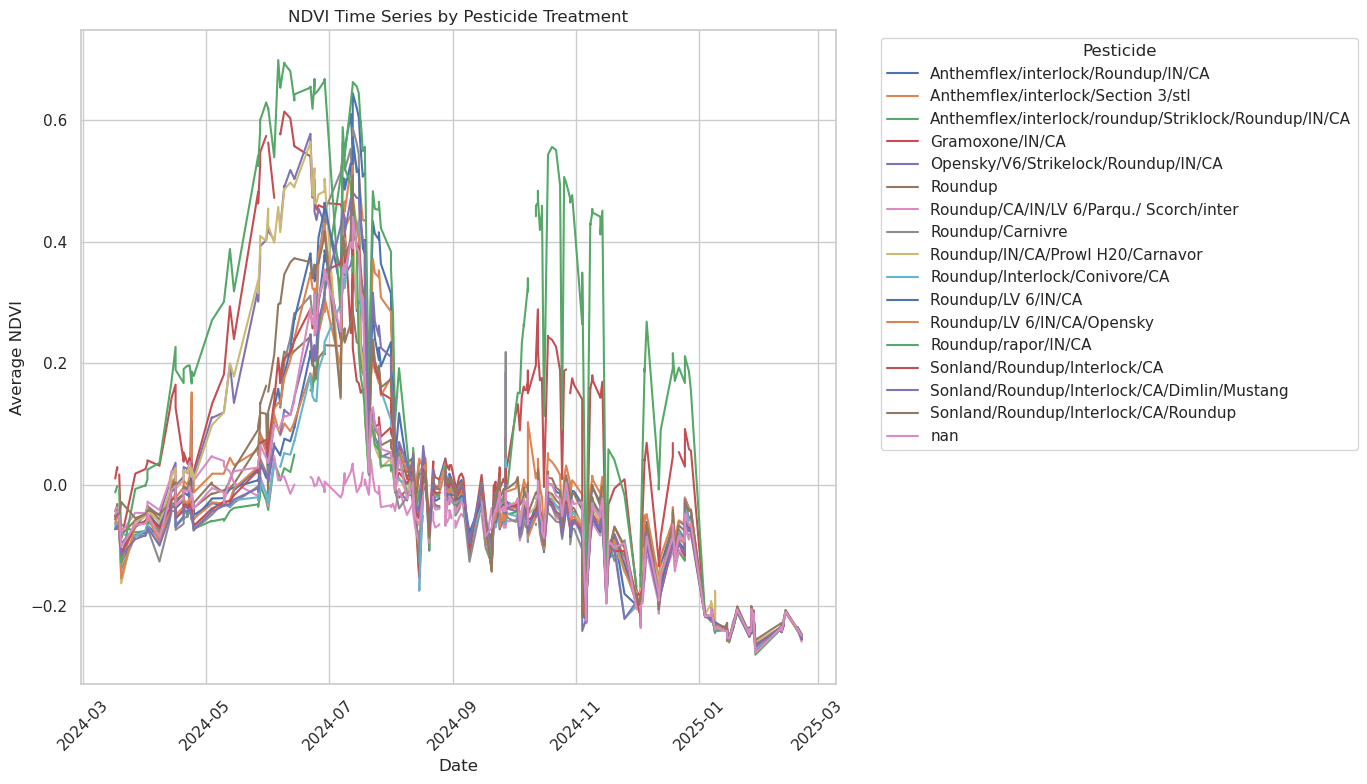

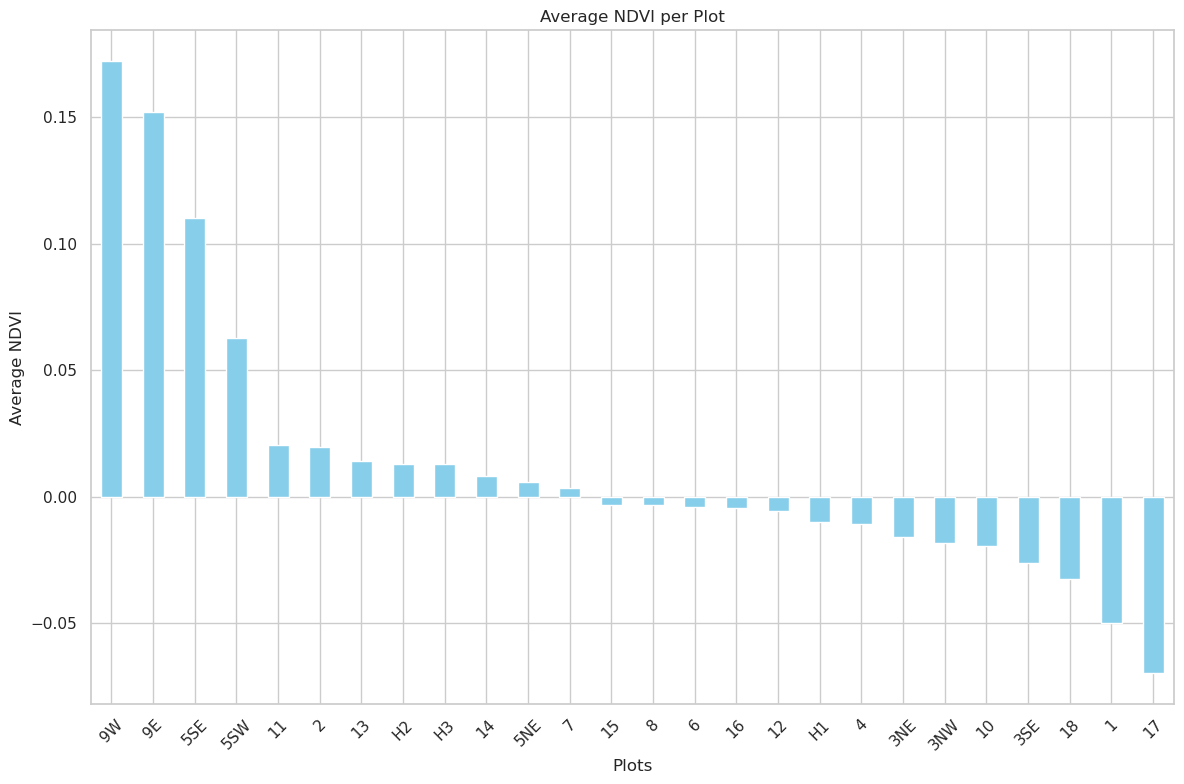

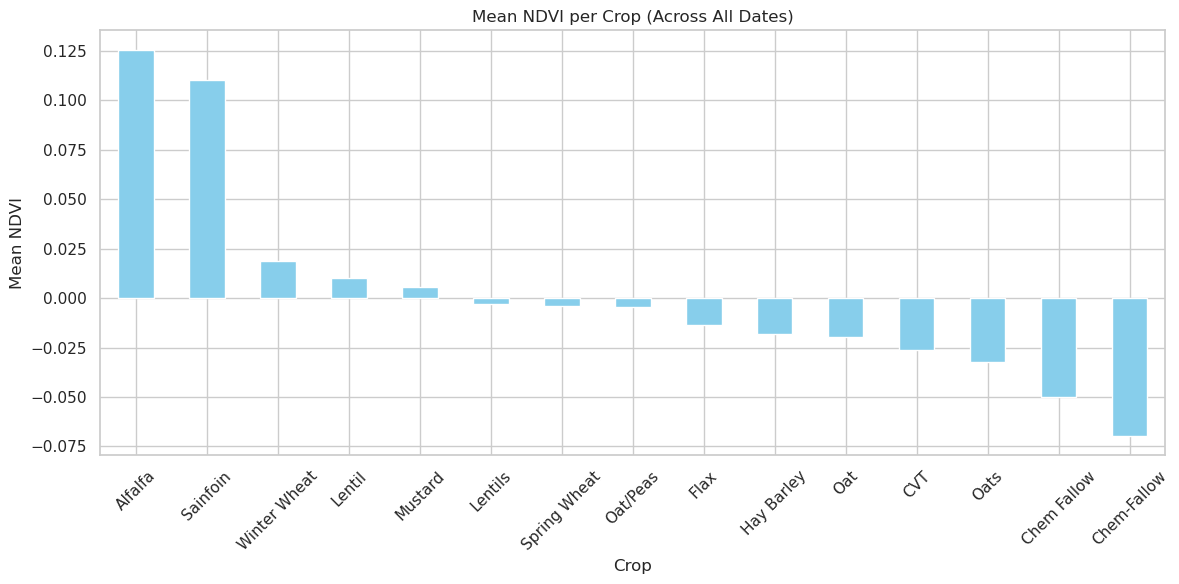

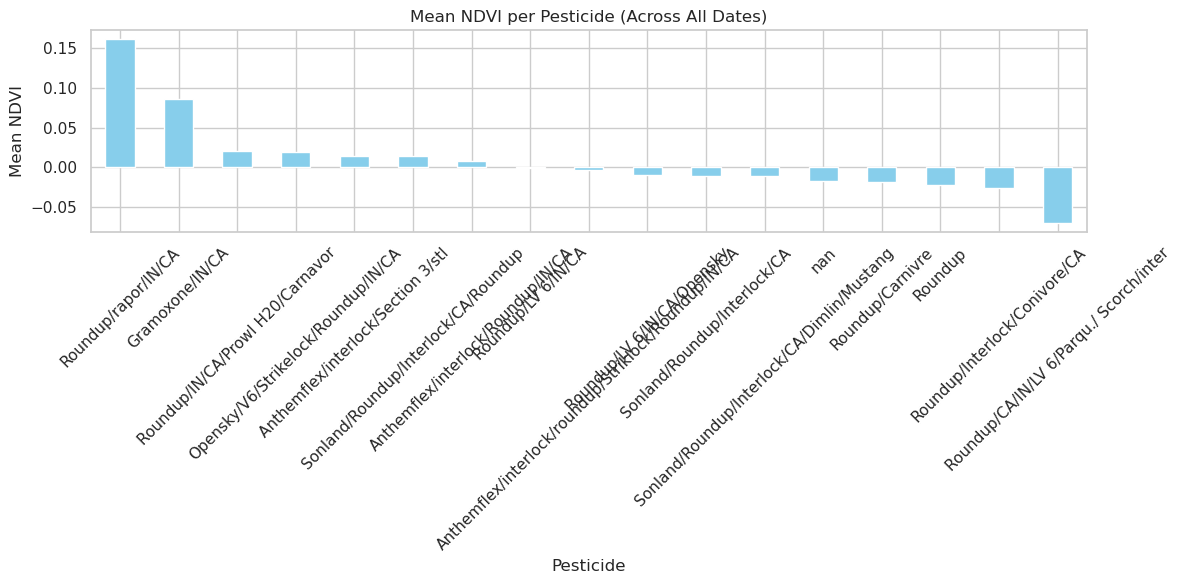

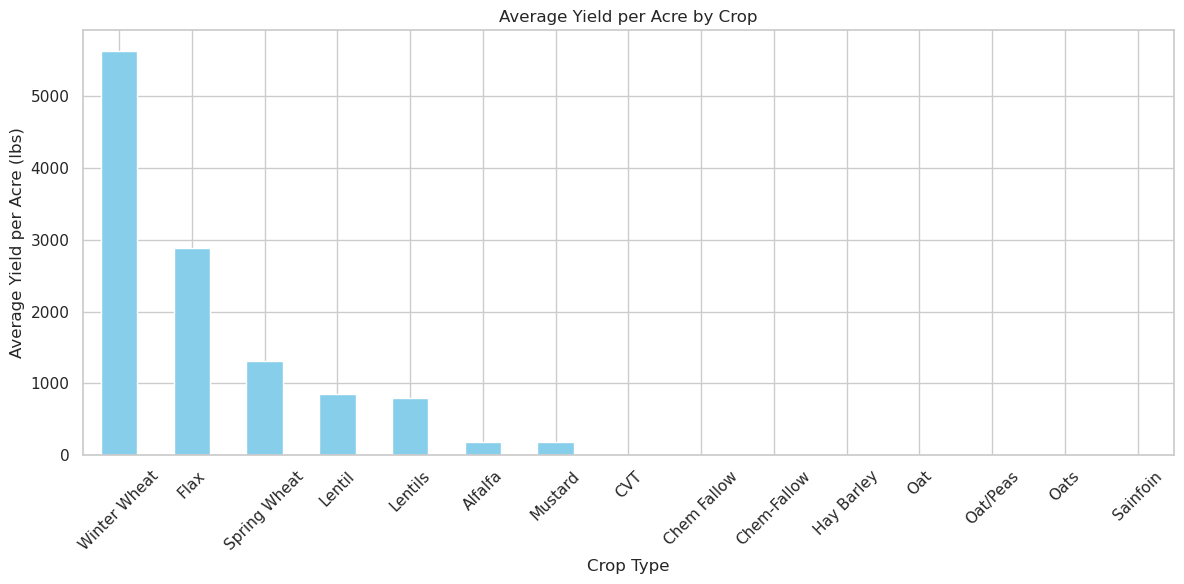

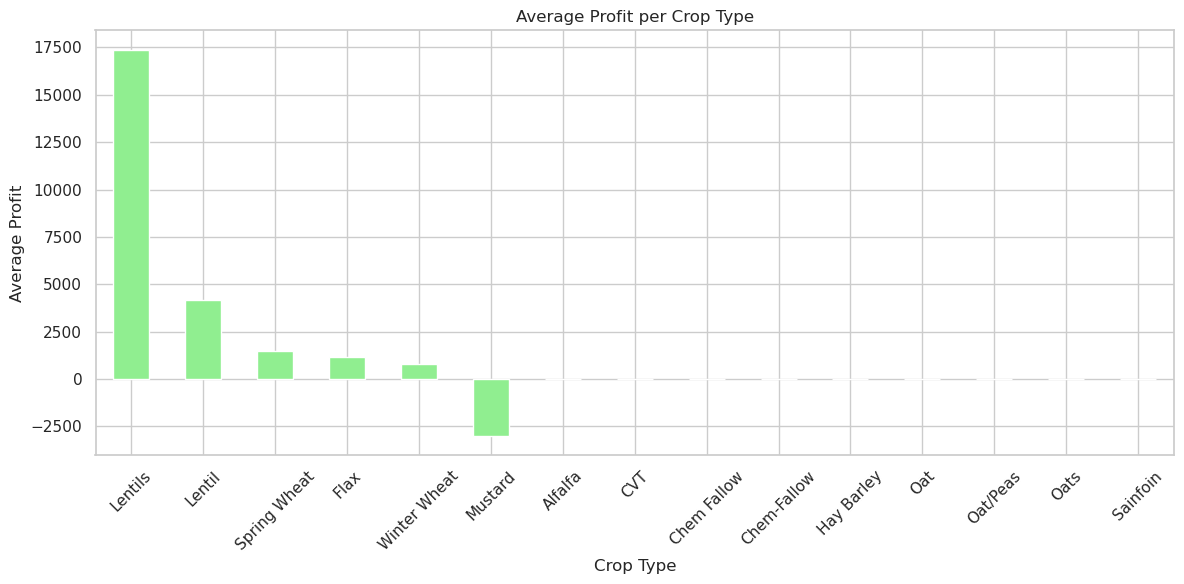

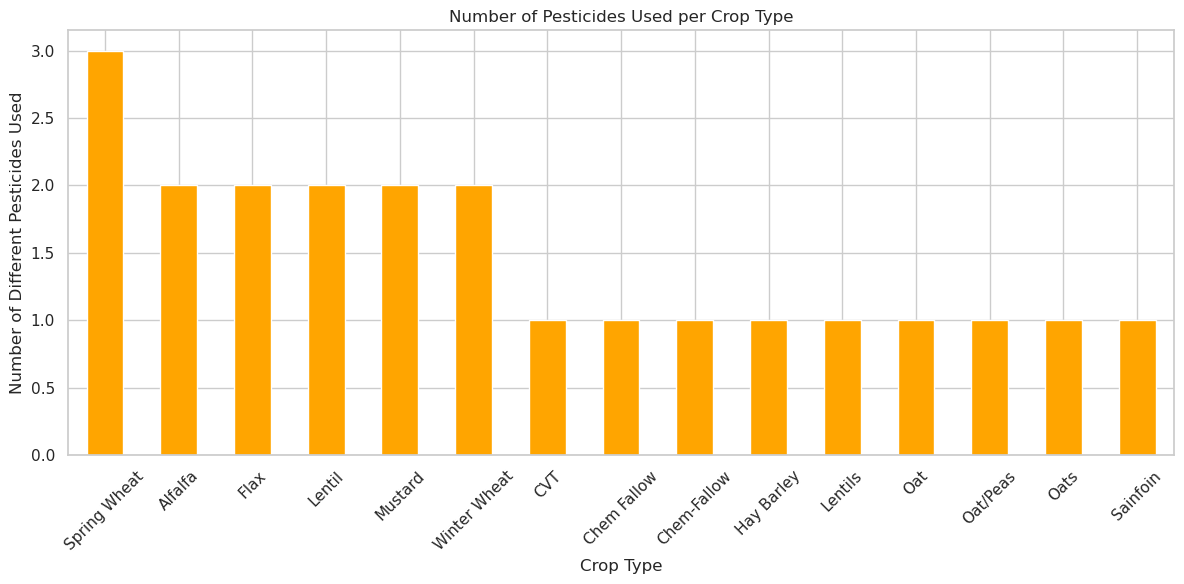

In [24]:
import os
import geopandas as gpd
import rasterstats
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# -----------------------------
# Setup and Load Data
# -----------------------------
ndvi_clipped_folder = "ndvi_clipped_to_fields"
shapefile_path = "fields_merge.geojson"

# Load and prepare shapefile
fields = gpd.read_file(shapefile_path)
fields = fields.to_crs("EPSG:32612")  # Adjust EPSG if needed
fields['Crop'] = fields['Crop'].astype(str)
fields['Pesticide'] = fields['Pesticide'].astype(str).fillna("None")

# Get sorted lists
crop_names = sorted(fields['Crop'].unique())
pesticide_names = sorted(fields['Pesticide'].unique())
ndvi_files = sorted([f for f in os.listdir(ndvi_clipped_folder) if f.endswith("_NDVI.tif")])

# -----------------------------
# NDVI Time Series by Crop and Pesticide
# -----------------------------
dates = []
crop_time_series = {crop: [] for crop in crop_names}
pesticide_time_series = {p: [] for p in pesticide_names}

for ndvi_file in ndvi_files:
    date_str = ndvi_file.split('_')[1]
    date = pd.to_datetime(date_str, format='%Y%m%d')
    ndvi_path = os.path.join(ndvi_clipped_folder, ndvi_file)
    stats = rasterstats.zonal_stats(fields, ndvi_path, stats="mean")
    dates.append(date)

    for crop in crop_names:
        crop_indices = fields.index[fields['Crop'] == crop]
        crop_means = [stats[i]['mean'] for i in crop_indices if stats[i]['mean'] is not None]
        crop_time_series[crop].append(sum(crop_means) / len(crop_means) if crop_means else None)

    for p in pesticide_names:
        pest_indices = fields.index[fields['Pesticide'] == p]
        pest_means = [stats[i]['mean'] for i in pest_indices if stats[i]['mean'] is not None]
        pesticide_time_series[p].append(sum(pest_means) / len(pest_means) if pest_means else None)

# Create DataFrames
ndvi_crop_df = pd.DataFrame(crop_time_series)
ndvi_crop_df['Date'] = dates
ndvi_crop_df = ndvi_crop_df.sort_values('Date')

ndvi_pest_df = pd.DataFrame(pesticide_time_series)
ndvi_pest_df['Date'] = dates
ndvi_pest_df = ndvi_pest_df.sort_values('Date')

# -----------------------------
# Plot 1: NDVI Time Series by Crop
# -----------------------------
plt.figure(figsize=(14, 8))
for crop in crop_names:
    plt.plot(ndvi_crop_df['Date'], ndvi_crop_df[crop], label=crop)
plt.xlabel("Date")
plt.ylabel("Average NDVI")
plt.title("NDVI Time Series by Crop Type")
plt.legend(title="Crop")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# -----------------------------
# Plot 2: NDVI Time Series by Pesticide
# -----------------------------
plt.figure(figsize=(14, 8))
for p in pesticide_names:
    plt.plot(ndvi_pest_df['Date'], ndvi_pest_df[p], label=p)
plt.xlabel("Date")
plt.ylabel("Average NDVI")
plt.title("NDVI Time Series by Pesticide Treatment")
plt.legend(title="Pesticide", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# -----------------------------
# Plot 3: Mean NDVI per plot (Bar Chart)
# -----------------------------
# Calculate the average NDVI for each plot (assuming 'time_series' is your DataFrame)
average_ndvi = time_series.drop(columns=['Date']).mean()  # Drop the Date column, then calculate the mean
# Sort the plots by average NDVI value (highest to lowest)
sorted_average_ndvi = average_ndvi.sort_values(ascending=False)
# Plot the average NDVI values
plt.figure(figsize=(12, 8))
sorted_average_ndvi.plot(kind='bar', color='skyblue')
plt.xlabel("Plots")
plt.ylabel("Average NDVI")
plt.title("Average NDVI per Plot")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# -----------------------------
# Plot 4: Mean NDVI per Crop (Bar Chart)
# -----------------------------
mean_ndvi_per_crop = long_crop_df.groupby("Crop")["NDVI"].mean().sort_values(ascending=False)
plt.figure(figsize=(12, 6))
mean_ndvi_per_crop.plot(kind="bar", color="skyblue")
plt.ylabel("Mean NDVI")
plt.title("Mean NDVI per Crop (Across All Dates)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# -----------------------------
# Plot 5: Mean NDVI per Pesticide (Bar Chart)
# -----------------------------
mean_ndvi_per_pest = long_pest_df.groupby("Pesticide")["NDVI"].mean().sort_values(ascending=False)
plt.figure(figsize=(12, 6))
mean_ndvi_per_pest.plot(kind="bar", color="skyblue")
plt.ylabel("Mean NDVI")
plt.title("Mean NDVI per Pesticide (Across All Dates)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# -----------------------------
# Plot 6: Yield per Acre by Crop
# -----------------------------
yield_per_crop = fields.groupby("Crop")["Yield_Per_Acre_lbs"].mean().sort_values(ascending=False)
plt.figure(figsize=(12, 6))
yield_per_crop.plot(kind="bar", color="skyblue")
plt.title("Average Yield per Acre by Crop")
plt.xlabel("Crop Type")
plt.ylabel("Average Yield per Acre (lbs)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# -----------------------------
# Plot 7: Profit per Crop
# -----------------------------
profit_per_crop = fields.groupby("Crop")["Profit"].mean().sort_values(ascending=False)
plt.figure(figsize=(12, 6))
profit_per_crop.plot(kind="bar", color="lightgreen")
plt.title("Average Profit per Crop Type")
plt.xlabel("Crop Type")
plt.ylabel("Average Profit")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# -----------------------------
# Plot 8: Number of Pesticides Used per Crop
# -----------------------------
pesticide_usage = fields.groupby("Crop")["Pesticide"].nunique().sort_values(ascending=False)
plt.figure(figsize=(12, 6))
pesticide_usage.plot(kind="bar", color="orange")
plt.title("Number of Pesticides Used per Crop Type")
plt.xlabel("Crop Type")
plt.ylabel("Number of Different Pesticides Used")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
